In [44]:
%pip install ftfy regex tqdm --user
%pip install pandas --user
%pip install wordcloud --user
%pip install sklearn --user
%pip install scikit-learn --user
%pip install Levenshtein --user
%pip install git+https://github.com/openai/CLIP.git --user

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider 

In [45]:
%pip install requests --user

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [1]:
import os
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import requests

from sklearn.metrics import average_precision_score

import json

/Users/polisetty/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
BASE_DIR = './dataset'

PATHS = {
    "annotations_root": f"{BASE_DIR}/Annotations/Annotations",
    "train_images": f"{BASE_DIR}/train/train",
    "val_images": f"{BASE_DIR}/val/val",
    "train_labels": f"{BASE_DIR}/Annotations/Annotations/train.json",
    "val_labels": f"{BASE_DIR}/Annotations/Annotations/val.json",
    "test_labels": f"{BASE_DIR}/Annotations/Annotations/test.json",
    "test_images": f"{BASE_DIR}/test/test"
}

SAVE_DIR = './checkpointaved'  
NUM_ANSWERS = 0  
CLIP_BACKBONE = "ViT-B/32" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Processing Data

In [5]:
from pathlib import Path
from tqdm import tqdm

def load_annotations(json_path):
    df = pd.read_json(json_path)
    return df[['image', 'question', 'answers', 'answer_type', 'answerable']]

def partition_dataset(df, test_frac=0.05):
    return train_test_split(df, test_size=test_frac, random_state=42, stratify=df[['answer_type', 'answerable']])

def show_hist(df, col_name):
    plt.hist(df[col_name])
    plt.title(f"Distribution: {col_name}")
    plt.show()

def show_pie(df, col_name):
    sizes = df[col_name].value_counts()
    plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%')
    plt.title(f"{col_name} breakdown")
    plt.show()

def inspect_data(df):
    show_pie(df, 'answer_type')
    show_pie(df, 'answerable')
    show_hist(df, 'answerable')

def count_unique_answers(df):
    vocab = set()
    for answers in df['answers']:
        for ans in answers:
            vocab.add(ans['answer'])
    return len(vocab)

def encode_images(df, img_dir, model, processor, device):
    all_img_feats = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Encoding Images"):
        try:
            img_path = Path(img_dir) / row['image']
            img = Image.open(img_path).convert("RGB")
            img_tensor = processor(img).unsqueeze(0).to(device)
            feat = model.encode_image(img_tensor).flatten(start_dim=1).cpu()
            all_img_feats.append(feat)
        except Exception as e:
            print(f"Skipped image {row['image']}: {e}")
            continue
    return all_img_feats

def encode_questions(df, model, device):
    all_q_feats = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Encoding Questions"):
        try:
            tokens = clip.tokenize(row['question']).to(device)
            feat = model.encode_text(tokens).flatten(start_dim=1).cpu()
            all_q_feats.append(feat)
        except Exception as e:
            print(f"Skipped question '{row['question']}': {e}")
            continue
    return all_q_feats

## Data Splitting

In [11]:
train_data = load_annotations(PATHS["train_labels"])
val_data = load_annotations(PATHS["val_labels"])

train_data, test_data = partition_dataset(train_data, test_frac=0.05)

train_data_subset, _ = train_test_split(
    train_data,
    train_size=0.1,  
    stratify=train_data[['answer_type', 'answerable']],
    random_state=42
)

train_data = train_data_subset.reset_index(drop=True)
val_data = val_data.sample(min(500, len(val_data)), random_state=42).reset_index(drop=True)
test_data = test_data.sample(min(500, len(test_data)), random_state=42).reset_index(drop=True)
print("Subset training size:", len(train_data))
print(train_data['answer_type'].value_counts())
print(train_data['answerable'].value_counts())

NUM_ANSWERS = count_unique_answers(train_data)
print(f"Vocabulary size (distinct answers): {NUM_ANSWERS}")

Subset training size: 1949
answer_type
other           1304
unanswerable     525
yes/no            91
number            29
Name: count, dtype: int64
answerable
1    1424
0     525
Name: count, dtype: int64
Vocabulary size (distinct answers): 5313


## Exploratory Data Analysis

### <a id='toc1_6_1_'></a>[Training Dataframe](#toc0_)

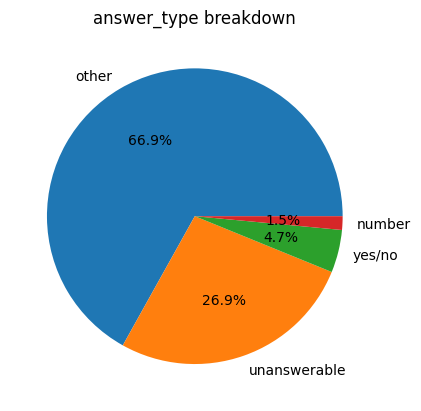

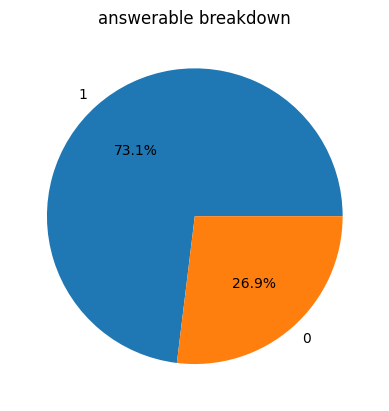

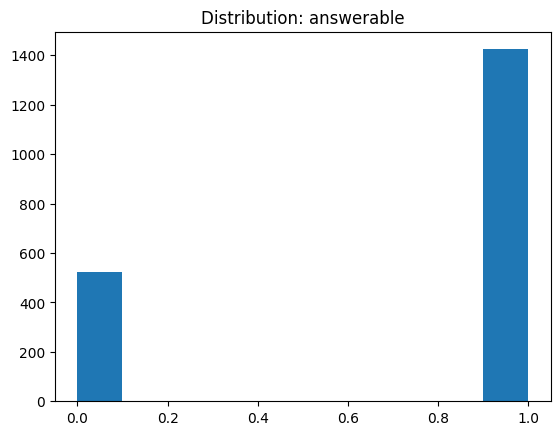

Unique answers found: 5313
Training sample count: 1949


In [12]:
inspect_data(train_data)

print("Unique answers found:", count_unique_answers(train_data))
print("Training sample count:", len(train_data))

### <a id='toc1_6_2_'></a>[Validation Dataframe](#toc0_)

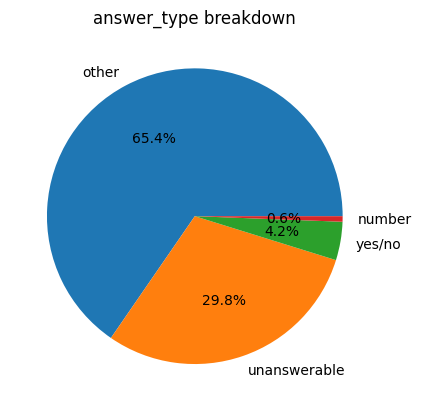

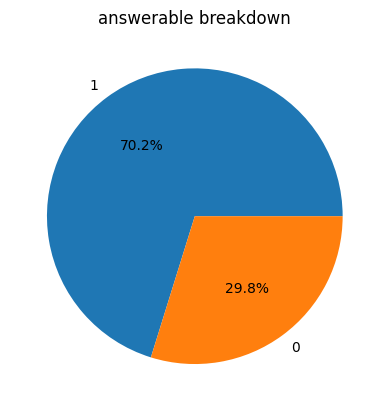

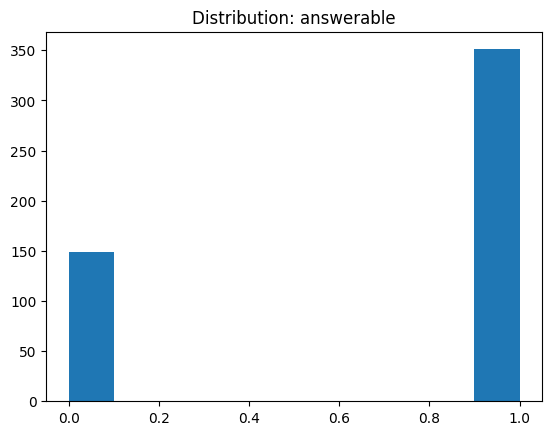

Unique answers in validation: 1657
Validation sample count: 500


In [13]:
inspect_data(val_data)

print("Unique answers in validation:", count_unique_answers(val_data))
print("Validation sample count:", len(val_data))

### <a id='toc1_6_3_'></a>[Testing Dataframe](#toc0_)

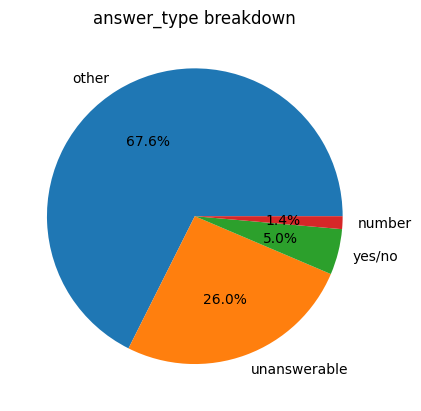

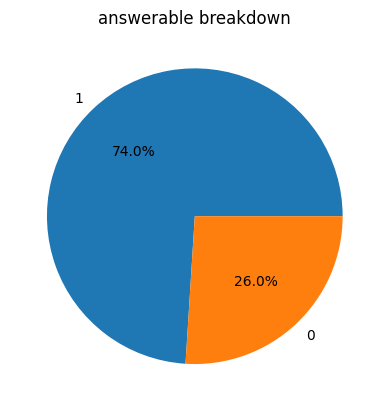

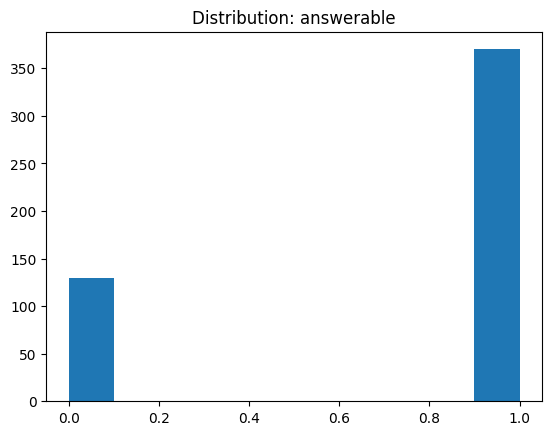

Unique answers in test set: 1622
Test sample count: 500


In [14]:
inspect_data(test_data)

print("Unique answers in test set:", count_unique_answers(test_data))
print("Test sample count:", len(test_data))

## Processing Images & Questions using CLIP model

In [22]:
import clip
import torch

clip_model, img_preprocessor = clip.load(CLIP_BACKBONE, device=device)
clip_model.eval().requires_grad_(False)

print(f"CLIP backbone loaded: {CLIP_BACKBONE}")

def save_pickle(obj, filename):
    with open(Path(SAVE_DIR) / filename, "wb") as f:
        pickle.dump(obj, f)
    print(f"Saved: {filename}")

print("Processing training set...")
train_img_feats = encode_images(train_data, PATHS["train_images"], clip_model, img_preprocessor, device)
train_q_feats = encode_questions(train_data, clip_model, device)
save_pickle(train_img_feats, "train_image_features.pkl")
save_pickle(train_q_feats, "train_question_features.pkl")

print("Processing validation set...")
val_img_feats = encode_images(val_data, PATHS["val_images"], clip_model, img_preprocessor, device)
val_q_feats = encode_questions(val_data, clip_model, device)
save_pickle(val_img_feats, "val_image_features.pkl")
save_pickle(val_q_feats, "val_question_features.pkl")

print("Processing test set...")
test_img_feats = encode_images(test_data, PATHS["train_images"], clip_model, img_preprocessor, device)  
test_q_feats = encode_questions(test_data, clip_model, device)
save_pickle(test_img_feats, "test_image_features.pkl")
save_pickle(test_q_feats, "test_question_features.pkl")

CLIP backbone loaded: ViT-B/32
Processing training set...


Encoding Questions: 100%|██████████| 1949/1949 [00:38<00:00, 50.54it/s]


Saved: train_image_features.pkl
Saved: train_question_features.pkl
Processing validation set...


Encoding Questions: 100%|██████████| 500/500 [00:09<00:00, 54.09it/s]


Saved: val_image_features.pkl
Saved: val_question_features.pkl
Processing test set...


Encoding Questions: 100%|██████████| 500/500 [00:09<00:00, 53.64it/s]


Saved: test_image_features.pkl
Saved: test_question_features.pkl


In [23]:
class VQADataset(Dataset):
    def __init__(self, df, ans_type_encoder=None, ans_encoder=None, model_name="RN50x64", img_feats=torch.tensor([]), q_feats=torch.tensor([])):
        super().__init__()

        self.df = df.reset_index(drop=True)
        self.image_embeddings = img_feats
        self.question_embeddings = q_feats
        self.answerable_flags = df['answerable'].to_numpy()

        self.global_answer_freq = Counter()

        self.per_q_answer_indices = []

        self._count_answers()

        self._assign_main_answers()

        print("Final vocab size:", len(self._get_vocab()))

        if ans_type_encoder is None:
            ans_type_encoder = OneHotEncoder(handle_unknown='ignore')
            ans_type_encoder.fit(self.augmented_df[['answer_type']])

        if ans_encoder is None:
            ans_encoder = OneHotEncoder(handle_unknown='ignore')
            ans_encoder.fit(self.augmented_df[['answer']])

        self.ans_encoder = ans_encoder
        self.ans_type_encoder = ans_type_encoder

        self.encoded_answers = ans_encoder.transform(self.augmented_df[['answer']]).toarray()
        self.encoded_answer_types = ans_type_encoder.transform(self.augmented_df[['answer_type']]).toarray()

        self.vocab = self.ans_encoder.categories_[0].tolist()

        self._build_answer_index_list()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (
            self.image_embeddings[idx],
            self.question_embeddings[idx],
            torch.tensor(self.encoded_answers[idx], dtype=torch.float32),
            torch.tensor(self.encoded_answer_types[idx], dtype=torch.float32),
            torch.tensor(self.per_q_answer_indices[idx], dtype=torch.long),
            torch.tensor(self.answerable_flags[idx], dtype=torch.float32)
        )

    def _count_answers(self):
        for answers in self.df['answers']:
            for a in answers:
                self.global_answer_freq.update([a['answer']])

    def _assign_main_answers(self):
        self.augmented_df = self.df.drop(columns=['answers']).copy()
        self.augmented_df['answer'] = None

        for idx, row in self.df.iterrows():
            temp_counter = Counter([a['answer'] for a in row['answers']])
            top = temp_counter.most_common()

            if len(top) == 1:
                chosen = top[0][0]
            elif len(top) > 1:
                global_top = self.global_answer_freq.most_common()
                candidates = [item[0] for item in top]
                common_overlap = [word for word, _ in global_top if word in candidates]
                if common_overlap:
                    chosen = common_overlap[0]
                else:
                    chosen = self._levenshtein_consensus(candidates)

            self.augmented_df.at[idx, 'answer'] = chosen

    def _levenshtein_consensus(self, candidates):
        min_score = float('inf')
        best_ans = None
        for a in candidates:
            score = sum(lev.distance(a, b) for b in candidates if a != b)
            if score < min_score:
                min_score = score
                best_ans = a
        return best_ans

    def _get_vocab(self):
        return self.augmented_df['answer'].unique()

    def _build_answer_index_list(self):
        for idx, row in self.df.iterrows():
            valid_indices = []
            for ans in row['answers']:
                text = ans['answer']
                if text in self.vocab:
                    valid_indices.append(self.vocab.index(text))
            while len(valid_indices) < 10:
                valid_indices.append(-1)
            self.per_q_answer_indices.append(valid_indices)

## Building Architecture

In [24]:
class CLIPVQABaseline(nn.Module):
    def __init__(self, num_classes, hidden_dim, model_name="ViT-B/32", device=torch.device("cpu")):
        super().__init__()

        self.device = device
        self.model_name = model_name

        self.loss_log = {'train': [], 'val': []}
        self.accuracy_log = {'train': [], 'val': [], 'test': []}
        self.vizwiz_accuracy_log = {'train': [], 'val': [], 'test': []}
        self.answerability_log = {'train': [], 'val': [], 'test': []}

        self.bce_loss = nn.BCELoss()

        self.clip_base, self.clip_preprocess = clip.load(model_name, device=device)
        for param in self.clip_base.parameters():
            param.requires_grad = False  

        embed_dim = self.clip_base.visual.output_dim + self.clip_base.text_projection.shape[1]

        self.projector = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, hidden_dim)
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

        self.ans_type_head = nn.Linear(hidden_dim, 4)

        self.ans_mask = nn.Linear(4, num_classes)
        self.sigmoid = nn.Sigmoid()

        self.ansability_proj = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, hidden_dim)
        )
        self.ansability_score = nn.Linear(hidden_dim, 1)
        self.ansability_sigmoid = nn.Sigmoid()

    def forward(self, img_feat, txt_feat):
        img_feat = torch.flatten(img_feat, start_dim=1)
        txt_feat = torch.flatten(txt_feat, start_dim=1)
        fused = torch.cat((img_feat, txt_feat), dim=1)

        ans_flag = self.ansability_proj(fused)
        ans_flag = self.ansability_score(ans_flag)
        ans_flag = self.ansability_sigmoid(ans_flag).squeeze()

        fused = self.projector(fused)
        ans_type = self.ans_type_head(fused)
        output_mask = self.sigmoid(self.ans_mask(ans_type))
        logits = self.classifier(fused)
        logits = logits * output_mask  

        return logits, ans_type, ans_flag

    def train_model(self, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10, save_path=None, save_every=1):
        for ep in range(1, epochs + 1):
            train_loss, train_acc, train_viz, train_ans = self._train_one_epoch(train_loader, criterion, optimizer)
            val_loss, val_acc, val_viz, val_ans = self._eval(val_loader, criterion)
            test_acc, test_viz, test_ans = self._test(test_loader)

            self.loss_log['train'].append(train_loss)
            self.loss_log['val'].append(val_loss)
            self.accuracy_log['train'].append(train_acc)
            self.accuracy_log['val'].append(val_acc)
            self.accuracy_log['test'].append(test_acc)
            self.vizwiz_accuracy_log['train'].append(train_viz)
            self.vizwiz_accuracy_log['val'].append(val_viz)
            self.vizwiz_accuracy_log['test'].append(test_viz)
            self.answerability_log['train'].append(train_ans)
            self.answerability_log['val'].append(val_ans)
            self.answerability_log['test'].append(test_ans)

            print(f"Epoch {ep:2d} | Loss: {train_loss:.3f}/{val_loss:.3f} | Acc: {train_acc:.3f}/{val_acc:.3f}/{test_acc:.3f}")
            print(f"         | VizWiz Acc: {train_viz:.3f}/{val_viz:.3f}/{test_viz:.3f}")
            print(f"         | Answerability: {train_ans:.3f}/{val_ans:.3f}/{test_ans:.3f}\n")

            if save_path and ep % save_every == 0:
                self.save_model(f"{save_path}epoch_{ep}.pth")

    def _train_one_epoch(self, loader, criterion, optimizer):
        self.train()
        total_loss, correct, total, viz_acc = 0.0, 0, 0, 0.0
        ans_true, ans_pred = [], []

        for batch in loader:
            img, txt, label, ans_type, all_ans, is_ans = [x.to(self.device) for x in batch]
            optimizer.zero_grad()
            out, pred_type, pred_ans = self.forward(img, txt)

            is_ans = 1 - is_ans
            pred_ans = 1.0 - pred_ans

            loss = criterion(out, label) + criterion(pred_type, ans_type) + self.bce_loss(pred_ans, is_ans)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(out, dim=1)
            target = torch.argmax(label, dim=1)

            correct += (pred == target).sum().item()
            total += len(label)
            viz_acc += sum(min(1, (pred[i] == all_ans[i]).sum().item() / 3) for i in range(len(pred)))
            ans_true += is_ans.tolist()
            ans_pred += pred_ans.tolist()

        return (
            total_loss / len(loader),
            correct / total,
            viz_acc / total,
            average_precision_score(ans_true, ans_pred, average='weighted')
        )

    @torch.no_grad()
    def _eval(self, loader, criterion):
        self.eval()
        total_loss, correct, total, viz_acc = 0.0, 0, 0, 0.0
        ans_true, ans_pred = [], []

        for batch in loader:
            img, txt, label, ans_type, all_ans, is_ans = [x.to(self.device) for x in batch]
            out, pred_type, pred_ans = self.forward(img, txt)

            is_ans = 1 - is_ans
            pred_ans = 1.0 - pred_ans

            loss = criterion(out, label) + criterion(pred_type, ans_type) + self.bce_loss(pred_ans, is_ans)
            total_loss += loss.item()

            pred = torch.argmax(out, dim=1)
            target = torch.argmax(label, dim=1)

            for i in range(len(label)):
                if torch.sum(label[i]) == 0:
                    continue
                correct += int(pred[i] == target[i])
                viz_acc += min(1, (pred[i] == all_ans[i]).sum().item() / 3)

            total += len(label)
            ans_true += is_ans.tolist()
            ans_pred += pred_ans.tolist()

        return (
            total_loss / len(loader),
            correct / total,
            viz_acc / total,
            average_precision_score(ans_true, ans_pred, average='weighted')
        )

    @torch.no_grad()
    def _test(self, loader):
        self.eval()
        correct, total, viz_acc = 0, 0, 0.0
        ans_true, ans_pred = [], []

        for batch in loader:
            img, txt, label, _, all_ans, is_ans = [x.to(self.device) for x in batch]
            out, _, pred_ans = self.forward(img, txt)

            is_ans = 1 - is_ans
            pred_ans = 1.0 - pred_ans

            pred = torch.argmax(out, dim=1)
            target = torch.argmax(label, dim=1)

            for i in range(len(label)):
                if torch.sum(label[i]) == 0:
                    continue
                correct += int(pred[i] == target[i])
                viz_acc += min(1, (pred[i] == all_ans[i]).sum().item() / 3)

            total += len(label)
            ans_true += is_ans.tolist()
            ans_pred += pred_ans.tolist()

        return (
            correct / total,
            viz_acc / total,
            average_precision_score(ans_true, ans_pred, average='weighted')
        )

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        out, ans_type, ans_flag = self.forward(image, question)
        return out, ans_type, 1.0 - ans_flag

    def test_image(self, image_path, question):
        self.eval()
        
        image_path = str(image_path)  

        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream=True).raw)
        else:
            image = Image.open(image_path)

        image_tensor = self.clip_preprocess(image).unsqueeze(0).to(self.device)
        img_feat = self.clip_base.encode_image(image_tensor).flatten(start_dim=1)

        question_tensor = clip.tokenize(question).to(self.device)
        txt_feat = self.clip_base.encode_text(question_tensor).float().flatten(start_dim=1)

        return self.predict(img_feat, txt_feat)

    def print_clip_info(self):
        print(f"CLIP Model: {self.model_name}")
        print(f"Input Resolution: {self.clip_base.visual.input_resolution}")
        print(f"Context Length: {self.clip_base.context_length}")
        print(f"Vocab Size: {self.clip_base.vocab_size}")
        print(f"Total Params: {sum(p.numel() for p in self.clip_base.parameters()):,}")

    def plot_loss(self):
        plt.plot(self.loss_log['train'], label='Train')
        plt.plot(self.loss_log['val'], label='Val')
        plt.title("Loss over Epochs")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.accuracy_log['train'], label='Train')
        plt.plot(self.accuracy_log['val'], label='Val')
        plt.title("Accuracy over Epochs")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        plt.plot(self.vizwiz_accuracy_log['train'], label='Train VizWiz')
        plt.plot(self.vizwiz_accuracy_log['val'], label='Val VizWiz')
        plt.title("VizWiz Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        plt.plot(self.answerability_log['train'], label='Train Answerability')
        plt.plot(self.answerability_log['val'], label='Val Answerability')
        plt.title("Answerability Score")
        plt.legend()
        plt.show()

## Loading Preprocessed Embeddings

In [25]:
from pathlib import Path

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

train_img_feats = load_pickle(Path(SAVE_DIR) / "train_image_features.pkl")
train_q_feats   = load_pickle(Path(SAVE_DIR) / "train_question_features.pkl")

val_img_feats = load_pickle(Path(SAVE_DIR) / "val_image_features.pkl")
val_q_feats   = load_pickle(Path(SAVE_DIR) / "val_question_features.pkl")

test_img_feats = load_pickle(Path(SAVE_DIR) / "test_image_features.pkl")
test_q_feats   = load_pickle(Path(SAVE_DIR) / "test_question_features.pkl")

## Preparing Data Loaders

In [26]:
train_dataset = VQADataset(
    df=train_data,
    model_name=CLIP_BACKBONE,
    img_feats=train_img_feats,
    q_feats=train_q_feats
)

answer_encoder = train_dataset.ans_encoder
ans_type_encoder = train_dataset.ans_type_encoder

with open(Path(SAVE_DIR) / "answer_onehotencoder.pkl", "wb") as f:
    pickle.dump(answer_encoder, f)
with open(Path(SAVE_DIR) / "answer_type_onehotencoder.pkl", "wb") as f:
    pickle.dump(ans_type_encoder, f)

val_dataset = VQADataset(
    df=val_data,
    ans_encoder=answer_encoder,
    ans_type_encoder=ans_type_encoder,
    model_name=CLIP_BACKBONE,
    img_feats=val_img_feats,
    q_feats=val_q_feats
)

test_dataset = VQADataset(
    df=test_data,
    ans_encoder=answer_encoder,
    ans_type_encoder=ans_type_encoder,
    model_name=CLIP_BACKBONE,
    img_feats=test_img_feats,
    q_feats=test_q_feats
)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Final vocab size: 434
Final vocab size: 141
Final vocab size: 164


## Training the Model

CLIP Model: ViT-B/32
Input Resolution: 224
Context Length: 77
Vocab Size: 49408
Total Params: 151,277,313
Epoch  1 | Loss: 4.976/2.725 | Acc: 0.437/0.524/0.454
         | VizWiz Acc: 0.333/0.362/0.320
         | Answerability: 0.607/0.694/0.697

Epoch  2 | Loss: 4.129/2.627 | Acc: 0.477/0.526/0.458
         | VizWiz Acc: 0.352/0.366/0.326
         | Answerability: 0.746/0.706/0.689

Epoch  3 | Loss: 3.877/2.654 | Acc: 0.486/0.532/0.456
         | VizWiz Acc: 0.357/0.371/0.327
         | Answerability: 0.791/0.708/0.677

Epoch  4 | Loss: 3.680/2.593 | Acc: 0.486/0.520/0.464
         | VizWiz Acc: 0.369/0.382/0.349
         | Answerability: 0.809/0.686/0.678

Epoch  5 | Loss: 3.439/2.605 | Acc: 0.499/0.498/0.442
         | VizWiz Acc: 0.386/0.381/0.347
         | Answerability: 0.838/0.705/0.699

Epoch  6 | Loss: 3.225/2.562 | Acc: 0.524/0.528/0.454
         | VizWiz Acc: 0.410/0.383/0.337
         | Answerability: 0.857/0.684/0.660

Epoch  7 | Loss: 3.040/2.562 | Acc: 0.541/0.514/0.444


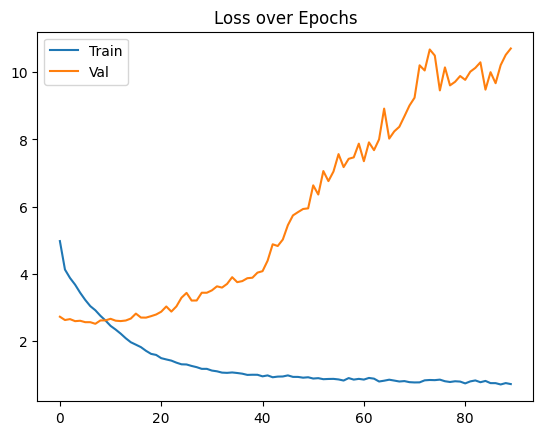

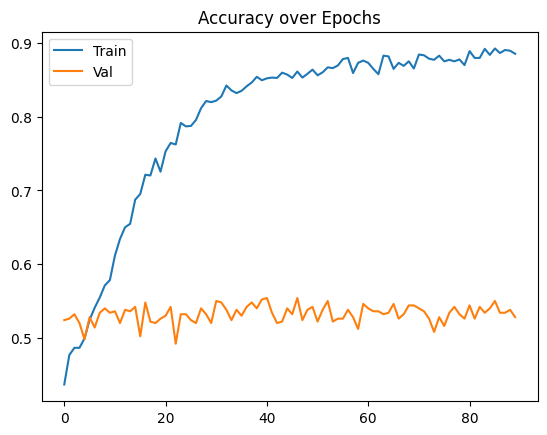

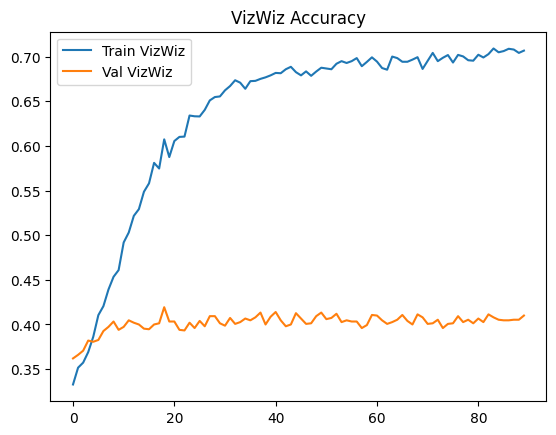

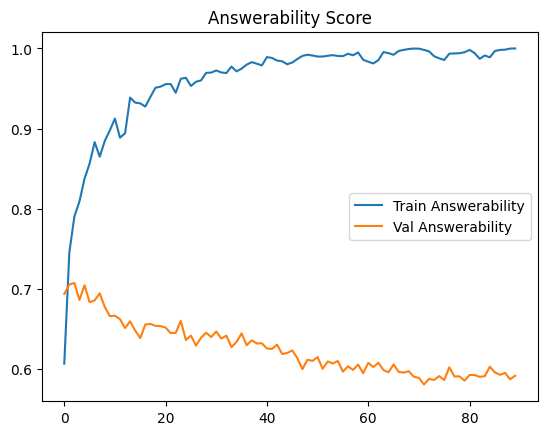

In [27]:
EPOCHS = 90
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 0
HIDDEN_DIM = 512
VOCAB_SIZE = len(train_dataset._get_vocab())  
MODEL_SAVE_DIR = Path(SAVE_DIR)
SAVE_INTERVAL = 5

model = CLIPVQABaseline(
    num_classes=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    model_name=CLIP_BACKBONE,
    device=device
).to(device)

model.print_clip_info()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.train_model(
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=EPOCHS,
    save_path=str(MODEL_SAVE_DIR) + "/", 
    save_every=SAVE_INTERVAL
)

model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()